[dataset link](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.3.0/1M_neurons)

In [1]:
import os
import simba as si
si.__version__

'1.1'

In [3]:
workdir = 'result_simba_rnaseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_rnaseq


In [4]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [5]:
adata_CG = si.read_10x_h5('./data/1M_neurons_filtered_gene_bc_matrices_h5.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata_CG

AnnData object with n_obs × n_vars = 1306127 × 27998
    var: 'gene_ids'

In [8]:
adata_CG.var_names_make_unique()

In [9]:
df_metadata = pd.read_csv('./data/analysis/clustering/graphclust/clusters.csv', index_col=0)
df_metadata.index.name = None
df_metadata['Cluster'] = 'cluster_' + df_metadata['Cluster'].astype(str)
print(df_metadata.shape)
df_metadata.head()

(1306127, 1)


,Cluster
AAACCTGAGATAGGAG-1,cluster_14
AAACCTGAGCGGCTTC-1,cluster_14
AAACCTGAGGAATCGC-1,cluster_37
AAACCTGAGGACACCA-1,cluster_4
AAACCTGAGGCCCGTT-1,cluster_20


In [11]:
adata_CG.obs = df_metadata

In [12]:
adata_CG

AnnData object with n_obs × n_vars = 1306127 × 27998
    obs: 'Cluster'
    var: 'gene_ids'

In [14]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
1306127 cells, 27998 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
1306127 cells, 22788 genes


In [15]:
si.pp.cal_qc_rna(adata_CG)

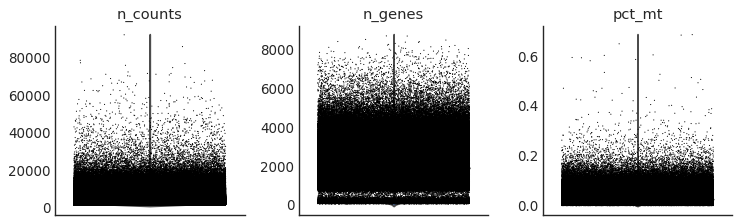

In [16]:
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

In [17]:
si.pp.normalize(adata_CG,method='lib_size')

In [18]:
si.pp.log_transform(adata_CG)

2000 variable genes are selected.


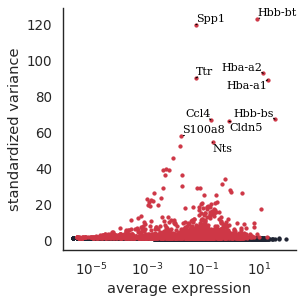

In [19]:
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)

In [20]:
si.tl.discretize(adata_CG,n_bins=5)

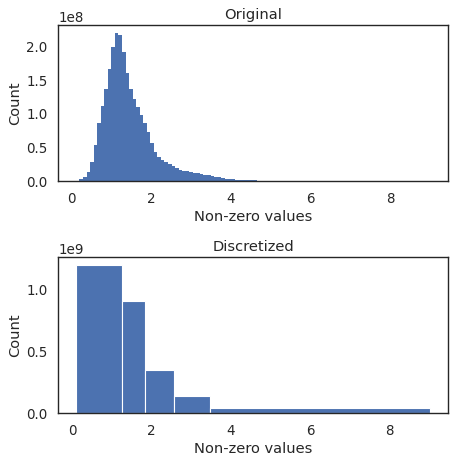

In [21]:
si.pl.discretize(adata_CG)

In [22]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=True,
                dirname='graph0')

relation0: source: C, destination: G
#edges: 84634858
relation1: source: C, destination: G
#edges: 74099104
relation2: source: C, destination: G
#edges: 40189514
relation3: source: C, destination: G
#edges: 14186556
relation4: source: C, destination: G
#edges: 3065315
Total number of edges: 216175347
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq/pbg/graph0" ...
Finished.


In [23]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['workers'] = 12 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.000109
`.settings.pbg_params['wd']` has been updated to 0.000109
Converting input data ...
[2021-10-27 20:14:59.424864] Using the 5 relation types given in the config
[2021-10-27 20:14:59.425251] Searching for the entities in the edge files...
[2021-10-27 20:18:55.307204] Entity type C:
[2021-10-27 20:18:55.307964] - Found 1306127 entities
[2021-10-27 20:18:55.308346] - Removing the ones with fewer than 1 occurrences...
[2021-10-27 20:18:55.769544] - Left with 1306127 entities
[2021-10-27 20:18:55.770258] - Shuffling them...
[2021-10-27 20:18:56.854065] Entity type G:
[2021-10-27 20:18:56.854702] - Found 2000 entities
[2021-10-27 20:18:56.854991] - Removing the ones with fewer than 1 occurrences...
[2021-10-27 20:18:56.855821] - Left with 2000 entities
[2021-10-27 20:18:56.856118] - Shuffling them...
[2021-10-27 20:18:56.872202] Preparing counts and dictionaries for entities and relation types:
[2021-10-27 20:18:56.874087] - Writing count of entity type

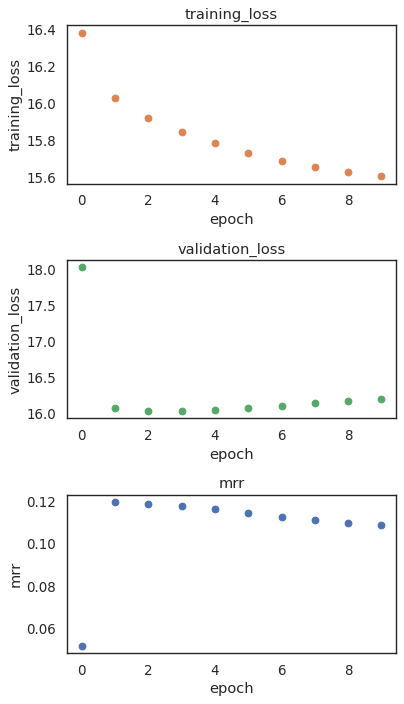

In [24]:
si.pl.pbg_metrics(fig_ncol=1)

In [25]:
dict_adata = si.read_embedding()
dict_adata

{'C': AnnData object with n_obs × n_vars = 1306127 × 50,
 'G': AnnData object with n_obs × n_vars = 2000 × 50}

In [26]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

In [27]:
## Add annotation of celltypes (optional)
adata_C.obs['Cluster'] = adata_CG[adata_C.obs_names,:].obs['Cluster'].copy()
adata_C

AnnData object with n_obs × n_vars = 1306127 × 50
    obs: 'Cluster'

In [28]:
si.tl.umap(adata_C,n_neighbors=10,n_components=2, n_jobs=12)

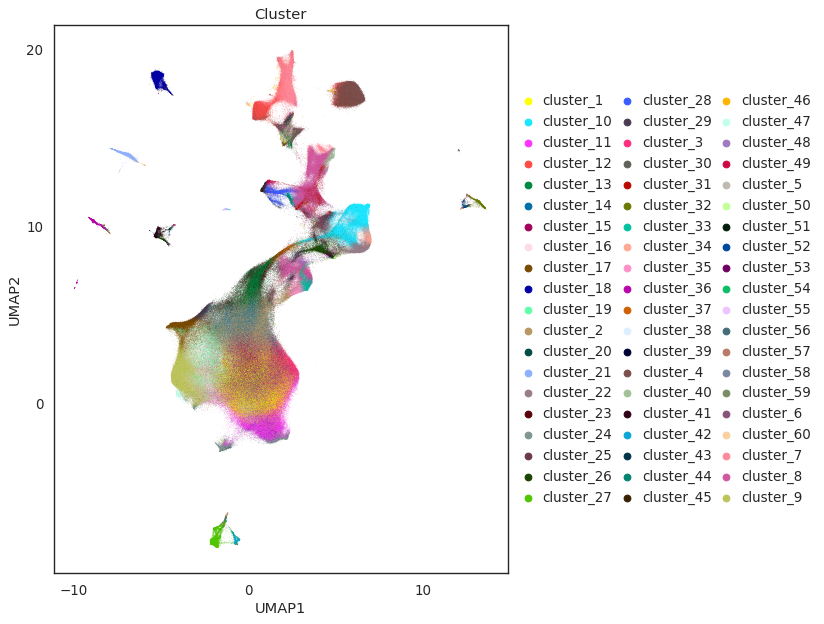

In [29]:
si.pl.umap(adata_C,color=['Cluster'],
           fig_size=(10,8),
           drawing_order='random',
           size=0.1,
           fig_legend_ncol=3,
           )

In [30]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])

Performing softmax transformation for query data 0;


In [31]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'Cluster']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

In [32]:
si.tl.umap(adata_all,n_neighbors=10,n_components=2, n_jobs=12)

In [33]:
palette_entity_anno = adata_C.uns['color']['Cluster_color'].copy()
palette_entity_anno['gene'] = "#607e95"

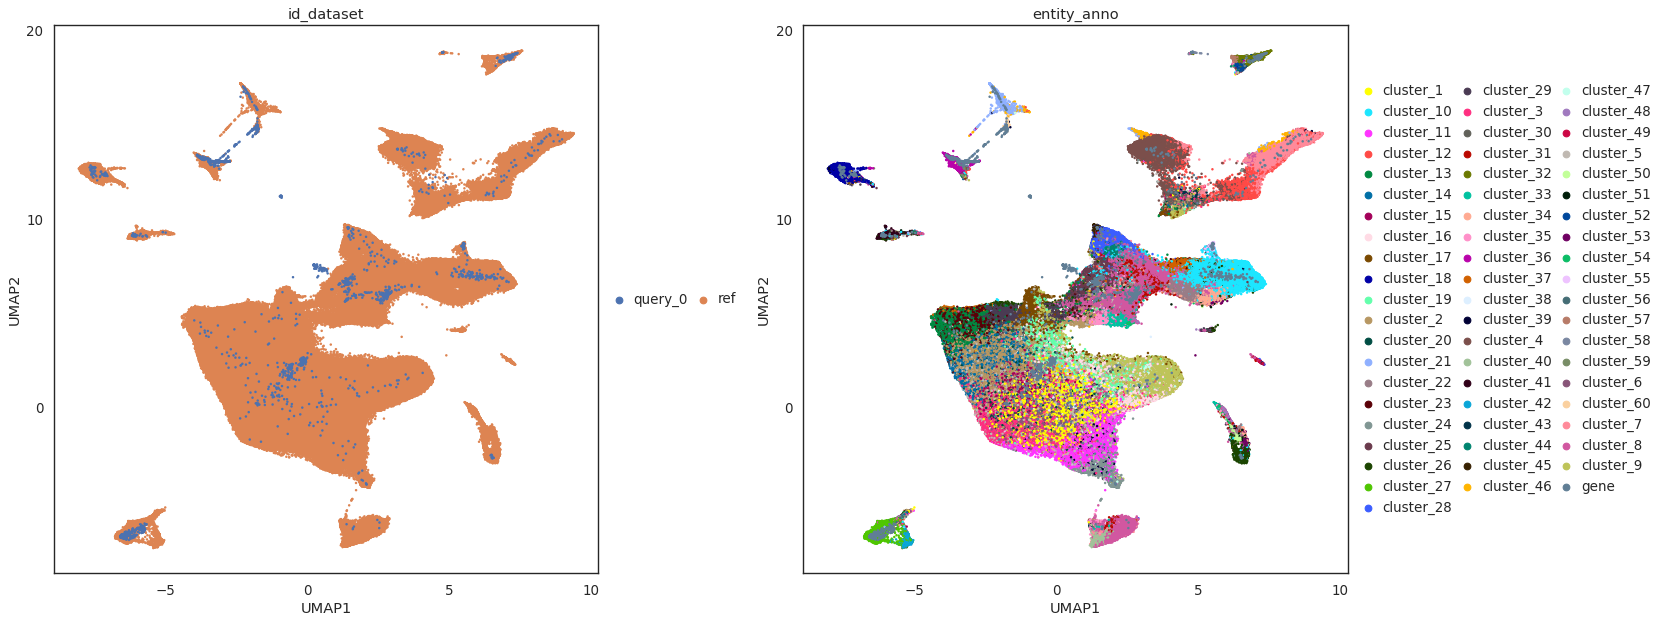

In [34]:
si.pl.umap(adata_all,color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(10,8),
           size=5,
           fig_legend_ncol=3,)

In [35]:
# find neighbor genes of given pins
query_genes = si.tl.query(adata_all,
                          pin=[6, 7],
                          use_radius=True, r=2,
                          obsm='X_umap',
                          anno_filter='entity_anno',
                          filters=['gene'])
print(query_genes.shape)
query_genes.head()

(153, 5)


,Cluster,id_dataset,entity_anno,distance,query
Pxdc1,NaN,query_0,gene,0.007740,0
Egln3,NaN,query_0,gene,0.046162,0
Pdpn,NaN,query_0,gene,0.075490,0
Fgfbp3,NaN,query_0,gene,0.076130,0
Notch2,NaN,query_0,gene,0.086966,0


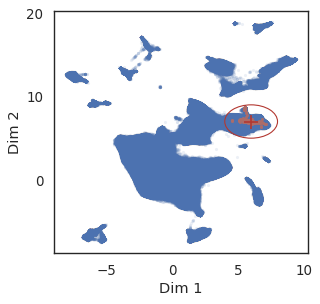

In [36]:
# show locations of pin points and its neighbor genes
si.pl.query(adata_all,
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_legend_ncol=1,
            fig_size=(4,4))

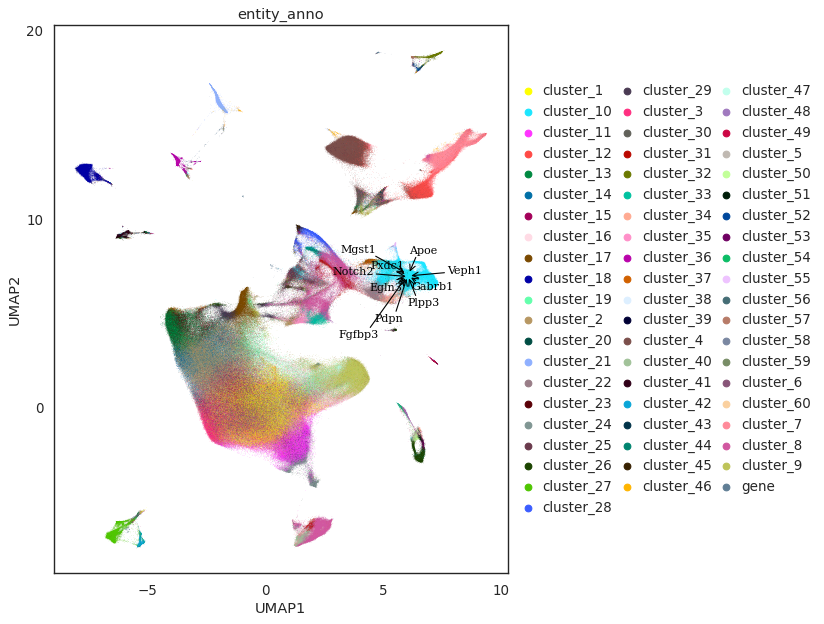

In [37]:
si.pl.umap(adata_all[::-1],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           show_texts=True,
           texts=query_genes.index[:10],
           text_expand=(1.2,1.4),
           fig_size=(10,8),
           size=0.1,
           fig_legend_ncol=3)

In [38]:
adata_CG.obsm['X_umap'] = adata_C[adata_CG.obs_names,].obsm['X_umap'].copy()

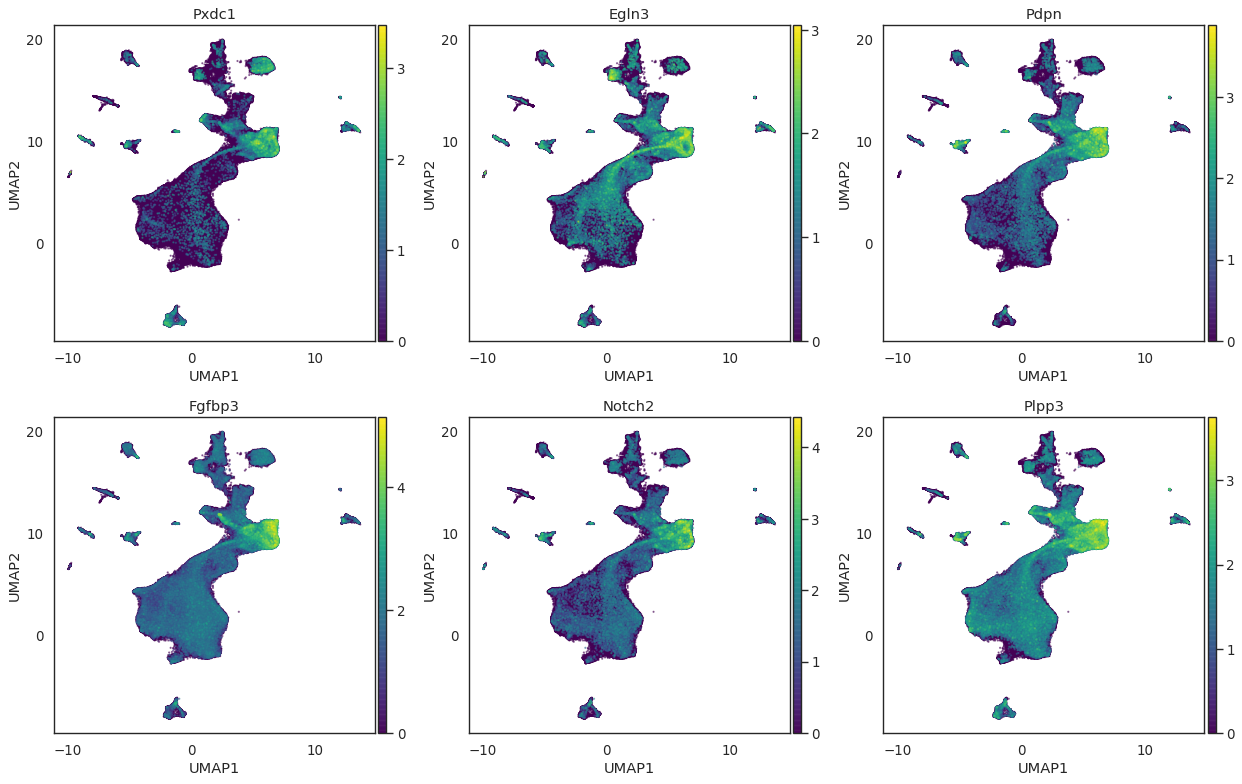

In [39]:
si.pl.umap(adata_CG,
           color=query_genes.index[:6],
           drawing_order='sorted',
           size=1,
           alpha=0.5,
           fig_ncol=3,
           save_fig=False)

In [40]:
# find neighbor genes of given pins
query_genes = si.tl.query(adata_all,
                          pin=[-7.5, 12.5],
                          use_radius=True, r=2,
                          obsm='X_umap',
                          anno_filter='entity_anno',
                          filters=['gene'])
print(query_genes.shape)
query_genes.head()

(52, 5)


,Cluster,id_dataset,entity_anno,distance,query
Reln,NaN,query_0,gene,0.035584,0
Npnt,NaN,query_0,gene,0.041992,0
Trp73,NaN,query_0,gene,0.062758,0
Ebf3,NaN,query_0,gene,0.063638,0
Lhx1,NaN,query_0,gene,0.106870,0


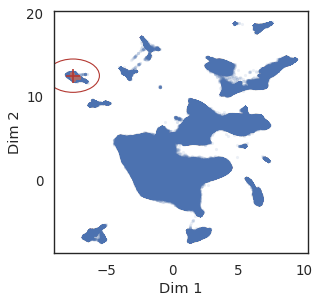

In [42]:
# show locations of pin points and its neighbor genes
si.pl.query(adata_all,
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_legend_ncol=1,
            fig_size=(4,4))

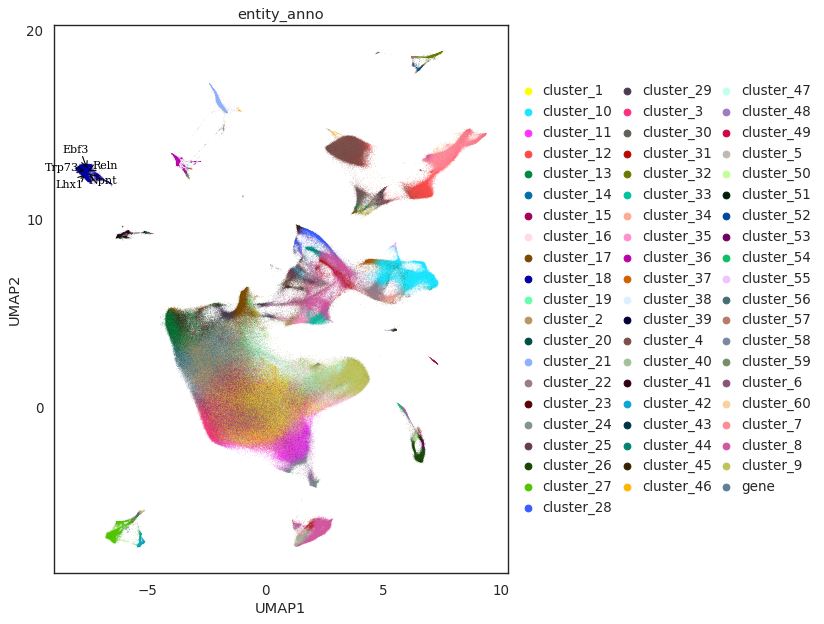

In [43]:
si.pl.umap(adata_all[::-1],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           show_texts=True,
           texts=query_genes.index[:5],
           text_expand=(1.2,1.4),
           fig_size=(10,8),
           size=0.1,
           fig_legend_ncol=3)

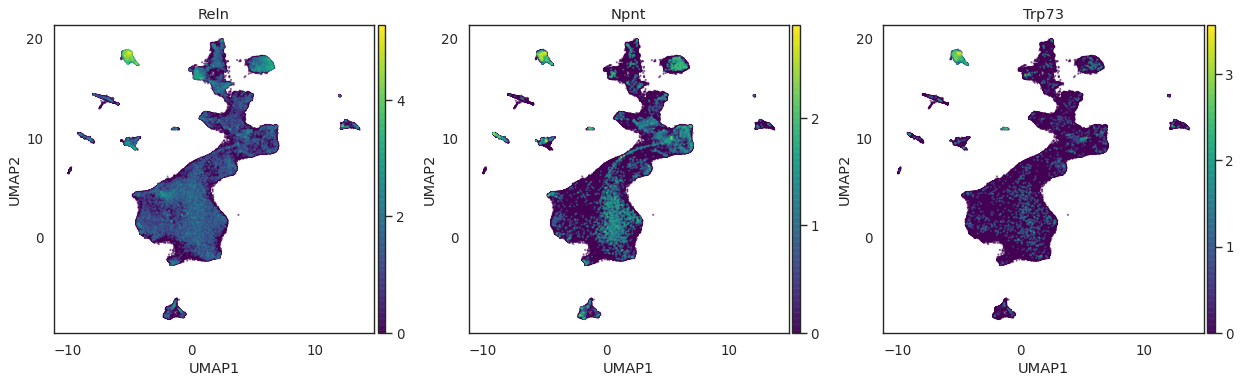

In [44]:
si.pl.umap(adata_CG,
           color=query_genes.index[:3],
           drawing_order='sorted',
           size=1,
           alpha=0.5,
           fig_ncol=3,
           save_fig=False)

In [45]:
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))